In [1]:
import torch
from feature_extractor import load_feature_extractor

In [2]:
model = load_feature_extractor()

---

In [3]:
x0 = torch.zeros((3,256,256))
x1 = torch.ones((3,256,256))
x2 = 2*torch.ones((3,256,256))
x3 = 3*torch.ones((3,256,256))
x01 = torch.cat((x0, x1),0)
x23 = torch.cat((x2, x3),0)
y01 = model(x01.unsqueeze(0))
y23 = model(x23.unsqueeze(0))

In [ ]:
x = torch.stack([x01,x23])
x.shape

In [ ]:
y = model(x)
y.shape

In [ ]:
torch.all(y[0] == y01)

In [ ]:
torch.all(y[1] == y23)

---

In [ ]:
x0 = torch.zeros((3,256,256))
x1 = torch.ones((3,256,256))
x01 = torch.cat((x0, x1),0)
y01 = model(x01.unsqueeze(0))

def tensor_mem(x):
    return x.element_size() * x.nelement() * 1e-9

In [ ]:
sizet = tensor_mem(y01)

In [ ]:
sizet

In [ ]:
sizet * 9573

In [ ]:
sizet * 16874

In [ ]:
sizet * 7630

In [ ]:
D = {
    'guatemala_train' : 1712 // 2,
    'guatemala_test' : 64 // 2,
    'guatemala_hold' : 206 // 2,
    'florence_train' : 12892 // 2,
    'florence_test' : 4536 // 2,
    'florence_hold' : 5668 // 2,
    'harvey_train' : 46028 // 2,
    'harvey_test' : 15430 // 2,
    'harvey_hold' : 14452 // 2,
    'matthew_train' : 27878 // 2,
    'matthew_test' : 8378 // 2,
    'matthew_hold' : 11672 // 2,
    'michael_train' : 45372 // 2,
    'michael_test' : 11314 // 2,
    'michael_hold' : 14316 // 2,
    'mexico_train' : 65542 // 2,
    'mexico_test' : 22822 // 2,
    'mexico_hold' : 15582 // 2,
    'midwest_train' : 17512 // 2,
    'midwest_test' : 5064 // 2,
    'midwest_hold' : 5216 // 2,
    'palu_train' : 62788 // 2,
    'palu_test' : 25120 // 2,
    'palu_hold' : 23670 // 2,
    'santa_train' : 25900 // 2,
    'santa_test' : 8452 // 2,
    'santa_hold' : 9558 // 2,
    'socal_train' : 20950 // 2,
    'socal_test' : 8544 // 2,
    'socal_hold' : 8444 // 2
}

import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.bar(range(len(D)), list(D.values()), align='center');
plt.xticks(range(len(D)), list(D.keys()), rotation=90);

In [ ]:
guatemala = D['guatemala_hold'] + D['guatemala_test'] + D['guatemala_train']
sizet * guatemala

In [ ]:
guatemala

In [ ]:
socal = D['socal_train'] + D['socal_test'] + D['socal_hold']
sizet * socal

In [ ]:
sizet * D['mexico_train']

---

In [1]:
import pandas as pd
from pathlib import Path

xbd_path = 'datasets/xbd'
subsets = ('/train_bldgs/', '/hold_bldgs/', '/test_bldgs/', '/tier3_bldgs/')
disaster_folders = os.listdir(xbd_path + subsets[0])

i_subset = 0
i_disaster = 0

print(list(Path(xbd_path + subsets[i_subset] + disaster_folders[i_disaster]).glob('*.csv*'))[0])
labels = pd.read_csv(list(Path(xbd_path + subsets[i_subset] + disaster_folders[i_disaster]).glob('*.csv*'))[0])
labels.columns = ['name', 'xcoords', 'ycoords', 'long', 'lat', 'class']
zone = lambda row: '_'.join(row['name'].split('_', 2)[:2])
labels['zone'] = labels.apply(zone, axis=1)
labels['zone'].value_counts()
#labels['zone'].value_counts()[labels['zone'].value_counts()==1].index.tolist()

datasets\xbd\train_bldgs\guatemala-volcano\guatemala-volcano_train_labels.csv


guatemala-volcano_00000025    201
guatemala-volcano_00000023    167
guatemala-volcano_00000015    131
guatemala-volcano_00000006     97
guatemala-volcano_00000024     67
guatemala-volcano_00000017     58
guatemala-volcano_00000026     30
guatemala-volcano_00000027     25
guatemala-volcano_00000019     22
guatemala-volcano_00000013     13
guatemala-volcano_00000018     12
guatemala-volcano_00000000     10
guatemala-volcano_00000007      9
guatemala-volcano_00000016      7
guatemala-volcano_00000001      4
guatemala-volcano_00000010      2
guatemala-volcano_00000002      1
Name: zone, dtype: int64

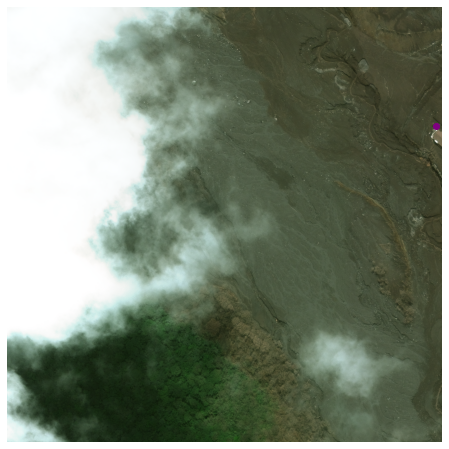

In [7]:
from visualization import plot_on_image

plot_on_image(labels, subsets[i_subset], 'guatemala-volcano_00000002')

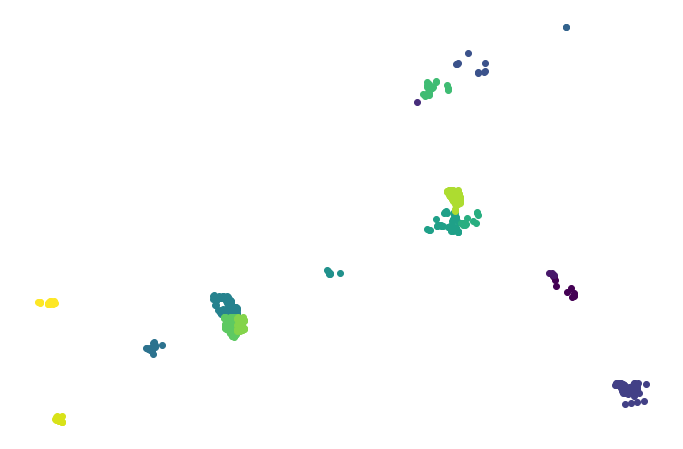

In [6]:
from visualization import plot_on_map

plot_on_map(labels, mapbox=False)

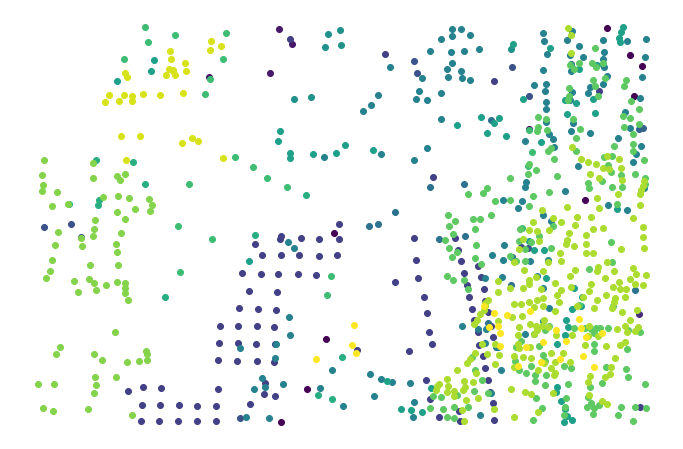

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from visualization import CmapString

cmap = CmapString(palette='viridis', domain=labels['zone'].values)

plt.figure(figsize=(12,8))
for _, row in labels.iterrows():
    plt.scatter(row['xcoords'], row['ycoords'], label=row['zone'], color=cmap.color(row['zone']))
plt.axis('off')
plt.show()

---

In [ ]:
import torch

a = torch.tensor([[0.8, 0.1, 0, 0],[0.7,0.6,0.3,0.2],[0.8,0.7,0.9,0.6]])

idx = torch.where(a < 0.5, 1, 0)

idx

In [ ]:
nz = torch.argmax(idx,dim=1)
nz

In [ ]:
torch.where(nz == 0, 4, nz)

---

In [4]:
import os
from pathlib import Path
import json
from tqdm import tqdm
import pandas as pd
from typing import List
import torch
import torchvision.transforms as tr
from PIL import Image
from torch_geometric.data import Data, Dataset
from feature_extractor import load_feature_extractor

In [5]:
path = 'datasets/xbd/hold_bldgs/'
disaster_folders = os.listdir(path)

list_labels = []
for disaster in disaster_folders:
    labels = pd.read_csv(list(Path(path + disaster).glob('*.csv*'))[0], index_col=0)
    labels.drop(columns=['long','lat'], inplace=True)
    zone = lambda row: '_'.join(row.name.split('_', 2)[:2])
    labels['zone'] = labels.apply(zone, axis=1)
    list_labels.append(labels)

In [6]:
processed_files = []
for labels in list_labels:
    zones = labels['zone'].value_counts()[labels['zone'].value_counts()>1].index.tolist()
    for zone in zones:
        if not (labels[labels['zone'] == zone]['class'] == 'un-classified').all():
            processed_files.append(f'{zone}.pt')

In [7]:
len(processed_files)

727